## Importing dependencies

In [1]:
import os
import joblib
from azureml.core import Workspace, Experiment
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.train.automl import AutoMLConfig

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


## Initialize workspace

In [2]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code EAFL6LUM6 to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
quick-starts-ws-141768
aml-quickstarts-141768
southcentralus
510b94ba-e453-4417-988b-fbdc37b55ca7


## Auto ML Experiment

In [3]:
# Choose a name for the run history container in the workspace.
# NOTE: update these to match your existing experiment name
experiment_name = 'data_quality_analysis'
project_folder = './catalogue-scorecard-project'

experiment = Experiment(ws, experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
data_quality_analysis,quick-starts-ws-141768,Link to Azure Machine Learning studio,Link to Documentation


## Create an AmlCompute cluster

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "comp"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS3_v2',#for GPU, use "STANDARD_NC6"
                                                           #vm_priority = 'lowpriority', # optional
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.

Running


## Data import

In [5]:
import pandas as pd

auto_ds_path="https://raw.githubusercontent.com/shatakshipachori/data_quality_analysis/main/catalogue-scorecard.csv"
data=TabularDatasetFactory.from_delimited_files(path=auto_ds_path)


## AutoML Configuration

In [6]:
import logging
import time

# TODO: Put your automl settings here
automl_settings = {
    "n_cross_validations":5,
    "primary_metric":'normalized_root_mean_squared_error',
    "enable_early_stopping":True,
    "experiment_timeout_minutes":30,
    "max_concurrent_iterations":5,
   }

# TODO: Put your automl config here
automl_config = AutoMLConfig(
    task='regression',
    compute_target='comp',
    training_data=data,
    label_column_name='score',
    **automl_settings
    )

## Submit the experiment

In [7]:
automl_run=experiment.submit(config=automl_config,show_output=True)

Running on remote.
No run_configuration provided, running on comp with default configuration
Running on remote compute: comp
Parent Run ID: AutoML_3efc1dc1-1856-4314-8f1d-6ee85f7cab26

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high car

## Run Details

In [8]:
from azureml.widgets import RunDetails
RunDetails(automl_run).show()
automl_run.wait_for_completion(show_output=True)

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…



****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary de

{'runId': 'AutoML_3efc1dc1-1856-4314-8f1d-6ee85f7cab26',
 'target': 'comp',
 'status': 'Completed',
 'startTimeUtc': '2021-04-01T23:31:28.457388Z',
 'endTimeUtc': '2021-04-01T23:49:07.571031Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'comp',
  'AMLSettingsJsonString': '{"path":null,"name":"data_quality_analysis","subscription_id":"510b94ba-e453-4417-988b-fbdc37b55ca7","resource_group":"aml-quickstarts-141768","workspace_name":"quick-starts-ws-141768","region":"southcentralus","compute_target":"comp","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_va

## Best Model

In [9]:
# Retrieve and save your best automl model.
best_automl_run,best_automl_model=automl_run.get_output()
best_run_metrics=automl_run.get_metrics()
for primary_metric in best_run_metrics:
    metric=best_run_metrics[primary_metric]
    print(primary_metric,metric)

experiment_status ['DatasetEvaluation', 'FeaturesGeneration', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'DatasetCrossValidationSplit', 'ModelSelection', 'BestRunExplainModel', 'ModelExplanationDataSetSetup', 'PickSurrogateModel', 'EngineeredFeatureExplanations', 'EngineeredFeatureExplanations', 'RawFeaturesExplanations', 'FailedModelExplanations']
experiment_status_description ['Gathering dataset statistics.', 'Generating features for the dataset.', 'Beginning to fit featurizers and featurize the dataset.', 'Completed fit featurizers and featurizing the dataset.', 'Generating individually featurized CV splits.', 'Beginning model selection.', 'Best run model explanations started', 'Model explanations data setup completed', 'Choosing LightGBM as the surrogate model for explanations', 'Computation of engineered features started', 'Computation of engineered features completed', 'Computation of raw features started', 'Failed to explain best model']
spearman_correlation 0.9991

In [10]:
print(best_automl_run)
best_automl_run

Run(Experiment: data_quality_analysis,
Id: AutoML_3efc1dc1-1856-4314-8f1d-6ee85f7cab26_0,
Type: azureml.scriptrun,
Status: Completed)


Experiment,Id,Type,Status,Details Page,Docs Page
data_quality_analysis,AutoML_3efc1dc1-1856-4314-8f1d-6ee85f7cab26_0,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Regression analysis using Linear Regression

In [11]:
data=data.to_pandas_dataframe()
data.head()

,_id,package,accessibility,completeness,freshness,metadata,usability,score,score_norm,grade,grade_norm,recorded_at,version
0,186,air-conditioned-and-cool-spaces-heat-relief-ne...,1,0.69,0.50,0.84,0.86,0.78,0.76,Silver,Silver,2019-12-17 20:24:09,v0.1.0
1,187,air-conditioned-public-places-cooling-centres,1,1.00,0.00,0.25,0.85,0.54,0.31,Bronze,Bronze,2019-12-17 20:24:09,v0.1.0
2,188,annual-summary-of-reportable-communicable-dise...,1,0.98,1.00,0.25,0.69,0.66,0.52,Bronze,Bronze,2019-12-17 20:24:09,v0.1.0
3,189,apartment-building-evaluation,1,0.96,1.00,0.75,0.94,0.91,1.00,Gold,Gold,2019-12-17 20:24:09,v0.1.0
4,190,apartment-building-registration,1,0.83,1.00,0.75,0.87,0.87,0.92,Gold,Gold,2019-12-17 20:24:09,v0.1.0


In [12]:
type(data)

pandas.core.frame.DataFrame

In [13]:
data.columns

Index(['_id', 'package', 'accessibility', 'completeness', 'freshness',
       'metadata', 'usability', 'score', 'score_norm', 'grade', 'grade_norm',
       'recorded_at', 'version'],
      dtype='object')

## Correlation between different variables

In [14]:
data.corr()

,_id,accessibility,completeness,freshness,metadata,usability,score,score_norm
_id,1.00,nan,-0.04,0.06,0.13,0.01,0.09,0.09
accessibility,nan,nan,nan,nan,nan,nan,nan,nan
completeness,-0.04,nan,1.00,0.16,0.35,0.27,0.41,0.41
freshness,0.06,nan,0.16,1.00,0.48,-0.13,0.81,0.81
metadata,0.13,nan,0.35,0.48,1.00,0.11,0.82,0.82
usability,0.01,nan,0.27,-0.13,0.11,1.00,0.28,0.28
score,0.09,nan,0.41,0.81,0.82,0.28,1.00,1.00
score_norm,0.09,nan,0.41,0.81,0.82,0.28,1.00,1.00


## Transformation

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

data=data.drop(['package','recorded_at','version'], axis=1)

#instantiate LabelEncoder
le=LabelEncoder()

#LabelEncode grade column of data
data['grade']=le.fit_transform(data['grade'])
data['grade_norm']=le.fit_transform(data['grade_norm'])

#inspecting encoded df
data.head()

,_id,accessibility,completeness,freshness,metadata,usability,score,score_norm,grade,grade_norm
0,186,1,0.69,0.50,0.84,0.86,0.78,0.76,2,2
1,187,1,1.00,0.00,0.25,0.85,0.54,0.31,0,0
2,188,1,0.98,1.00,0.25,0.69,0.66,0.52,0,0
3,189,1,0.96,1.00,0.75,0.94,0.91,1.00,1,1
4,190,1,0.83,1.00,0.75,0.87,0.87,0.92,1,1


## Defining variables

In [16]:
#independant variables
X=pd.DataFrame(np.c_[data['grade'],data['completeness'],data['freshness'],data['metadata'],data['usability']],columns=['grade','completeness','freshness','metadata','usability'])
#dependant variable
y=data['score']

## Import the class

In [17]:
from sklearn.model_selection import train_test_split
import argparse
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Model Fitting

In [18]:
from sklearn.linear_model import LinearRegression

#instantiate
linreg=LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Model Training

In [19]:
print(linreg.intercept_)
print(linreg.coef_)

0.11379645481715972
[0.00692953 0.05092957 0.1773736  0.22855186 0.39687087]


## Model Prediction

In [20]:
y_pred=linreg.predict(X_test)
y_pred

array([0.87024761, 0.8672801 , 0.68069894, ..., 0.55507848, 0.84780795,
       0.57781788])

## Model Accuracy (Root mean squared error)

In [21]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

0.014473932939290456


## 

## Visualizations

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

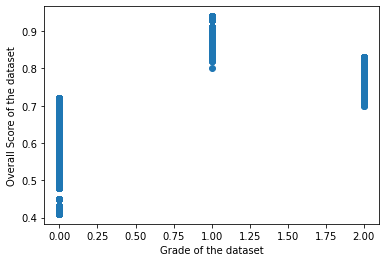

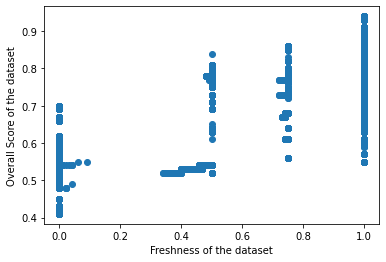

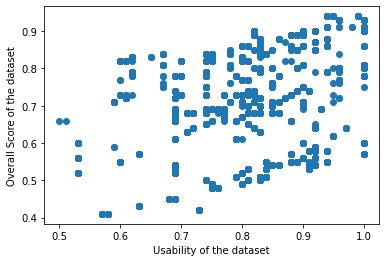

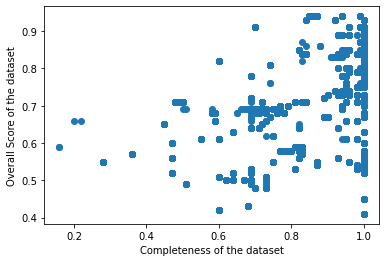

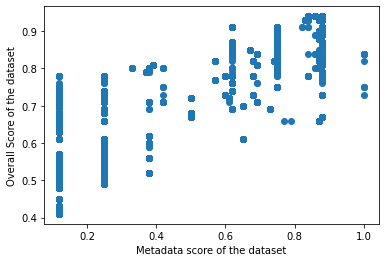

In [23]:
plt.scatter(data['grade'],data['score'])
plt.xlabel('Grade of the dataset')
plt.ylabel('Overall Score of the dataset')
plt.show()
plt.scatter(data['freshness'],data['score'])
plt.xlabel('Freshness of the dataset')
plt.ylabel('Overall Score of the dataset')
plt.show()
plt.scatter(data['usability'],data['score'])
plt.xlabel('Usability of the dataset')
plt.ylabel('Overall Score of the dataset')
plt.show()
plt.scatter(data['completeness'],data['score'])
plt.xlabel('Completeness of the dataset')
plt.ylabel('Overall Score of the dataset')
plt.show()
plt.scatter(data['metadata'],data['score'])
plt.xlabel('Metadata score of the dataset')
plt.ylabel('Overall Score of the dataset')
plt.show()